In [13]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import pickle
import tensorflow as tf
import altair as alt
import collections
from sklearn.model_selection import train_test_split


from src.clean_data import clean_books, clean_reviews, scale_data, review_map_id
from src.load_data import read_reviews, read_books
from src.item_recommender import ItemRecommender
from src.CFModel import CFModel, build_model, compute_scores, book_neighbors, user_recommendations

In [5]:
books = pd.read_csv('data/cleaned_wo_one_rating_books_mystery.csv')

In [6]:
books.set_index('book_id', drop=True, inplace=True)

In [35]:
books.head(1)

,title,num_pages,is_ebook,link,average_rating,ratings_count,text_reviews_count,author_id,publisher,similar_books
book_id,,,,,,,,,,
10000063,The Two Deaths of Daniel Hayes,390,0,https://www.goodreads.com/book/show/10000063-the-two-deaths-of-daniel-hayes,3.49,1698,297,38652,NaN,"['30195', '525677', '23154766', '9583669', '9843996', '349508', '17414656', '2187560', '6591518', '9526552', '17262454', '9999576', '6646102', '7950149', '11276223', '10038051', '9967897', '16066925']"


In [37]:
books.is_ebook.sum()/len(books)

0.3314668058653253

In [7]:
reviews = pd.read_csv('data/cleaned_wo_one_rating_reviews_mystery.csv')

In [8]:
reviews.head()

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
0,d23dc89ab32cd864e54d18369751163b,102489,37120,3,2001-01-01 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,196084
1,c7613da4cbd48baa83efec99b4dd6a41,102489,96299,3,2001-01-11 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,79030
2,469b9d160ad68ce84b6cac4585fb226a,102489,82887,4,2001-01-25 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,442783
3,9f4fd2c20177f66fe5832ec299fb4bbf,102489,85615,2,2001-01-29 00:00:00,0,0,d889b42d9eb7b80e02f24830e27c6389,552719
4,0c7a29c98c4f11b409235d9c22a2455b,102489,50050,4,2001-02-02 00:00:00,1,0,d889b42d9eb7b80e02f24830e27c6389,238117


### CF baseline with normal gradient descent

In [9]:
# model_base = build_model(reviews, embedding_dim=30, init_stddev=0.05, 
#                     regularization_coeff=0.0,
#                     gravity_coeff=0.0, optimizer = tf.train.GradientDescentOptimizer)

In [11]:
# model_base.train(num_iterations=50)

### CF model with adam optimizer

In [14]:
# matrix factorization without regularization with adam optimizer
# adam optimizer -> adaptive moment estimation with changing learning rate 
# https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

model_adam = build_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.0,
                    gravity_coeff=0.0)

 iteration 50: train_error=0.237671, regularization_error=0.000000, gravity_loss=0.000000, test_error=37.896072

[{'train_error': 0.23767081,
  'regularization_error': 0.0,
  'gravity_loss': 0.0,
  'test_error': 37.896072}]

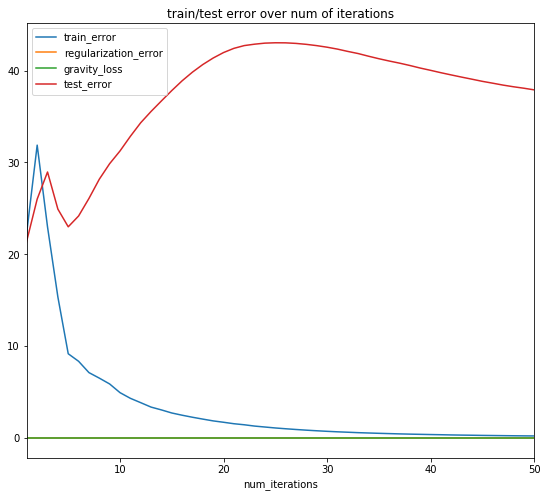

In [15]:
model_adam.train(num_iterations=50)

 iteration 1000: train_error=0.061354, regularization_error=0.000000, gravity_loss=0.000000, test_error=272.3146972

[{'train_error': 0.061354138,
  'regularization_error': 0.0,
  'gravity_loss': 0.0,
  'test_error': 272.3147}]

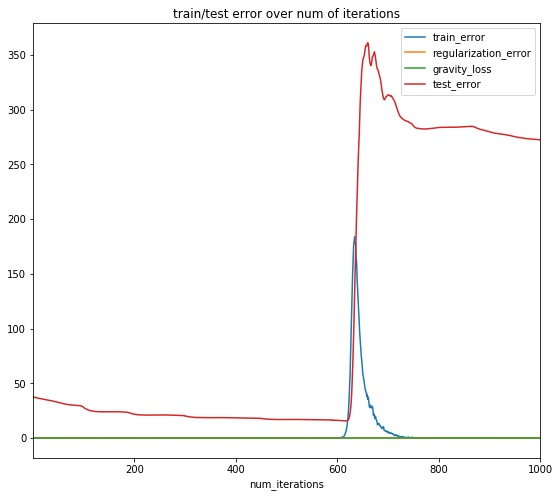

In [16]:
model_adam.train(num_iterations=1000)

In [18]:
# save model to disk
filename = 'model_adam.sav'
pickle.dump(model_adam, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

### CF model with regularization, gravity and adam optimizer

In [22]:
# A CFModel object that uses a regularized loss, gravity loss with adam optimizer
model = build_model(reviews, embedding_dim=30, init_stddev=0.05, 
                    regularization_coeff=0.1,
                    gravity_coeff=1.0)

 iteration 50: train_error=0.256318, regularization_error=0.681615, gravity_loss=0.437977, test_error=9.0513131

[{'train_error': 0.25631842,
  'regularization_error': 0.6816148,
  'gravity_loss': 0.4379768,
  'test_error': 9.051313}]

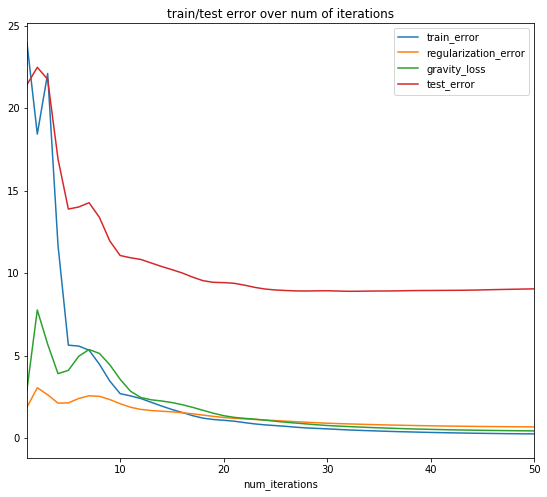

In [23]:
model.train(num_iterations=50)

 iteration 1000: train_error=0.191909, regularization_error=0.631692, gravity_loss=0.359475, test_error=9.45186761

[{'train_error': 0.191909,
  'regularization_error': 0.63169193,
  'gravity_loss': 0.35947484,
  'test_error': 9.451867}]

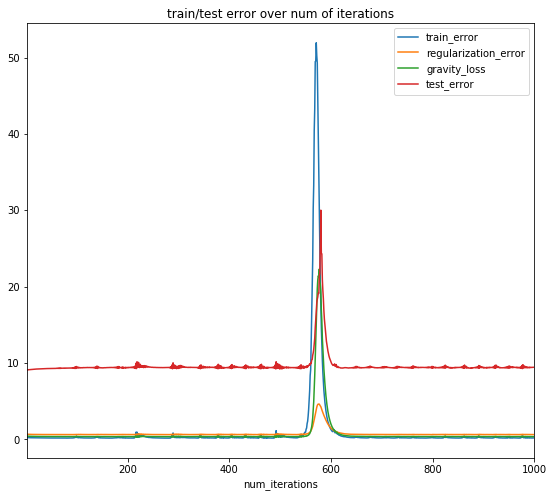

In [16]:
model.train(num_iterations=1000)

### get recommendations for a given user

In [75]:
#example with user 'd889b42d9eb7b80e02f24830e27c6389'
user_id = 'fca26c34be8fe623ee340061f1281796'
user_recommendations(books, reviews, model, user_id, measure='cosine', k=6)

The highest recommendations for user fca26c34be8fe623ee340061f1281796.


,cosine score,titles,is_ebook,average_rating,ratings_count,text_reviews_count
book_id,,,,,,
747649,0.9096015691757202,"Nervous Laughter (Thomas Black, #3)",0,3.88,227,9
6453167,0.904136061668396,"Deception on His Mind (Inspector Lynley, #9)",1,4.03,381,8
26515223,0.8971420526504517,"Cold Florida (Foggy Moskowitz, #1)",0,4.02,43,20
2564167,0.8938326835632324,"Indigo Slam (Elvis Cole, #7)",0,4.16,88,8
1219864,0.8932629227638245,"The Death Collectors (Carson Ryder, #2)",0,3.92,34,4
2239028,0.8918185234069824,"A Cold-Blooded Business (Kate Shugak, #4)",0,4.12,47,5


In [72]:
reviews[reviews.old_user_id == 'fca26c34be8fe623ee340061f1281796']

,review_id,user_id,book_id,rating,timestamp,n_votes,n_comments,old_user_id,old_book_id
3765,fb89469b4f0bc239db8003b0989d0f9b,119717,23582,1,2007-08-06 06:06:11,0,0,fca26c34be8fe623ee340061f1281796,1653254
3844,714613442f497a577f9f5af133864142,119717,17437,4,2007-08-07 16:56:36,3,0,fca26c34be8fe623ee340061f1281796,149576
3846,0d9147c5c9f7fe6efd127743bd5b90fe,119717,12590,2,2007-08-07 16:58:55,1,0,fca26c34be8fe623ee340061f1281796,1328722
3847,bd0f80100980a41524fafc29cb41be20,119717,10680,5,2007-08-07 17:02:17,1,0,fca26c34be8fe623ee340061f1281796,1293660
3848,85eb8a30584cafb745d4df25b26a9ecf,119717,99148,3,2007-08-07 17:03:14,1,0,fca26c34be8fe623ee340061f1281796,84785
...,...,...,...,...,...,...,...,...,...
1543637,59c3e50f646e51b35d708b81771a7a2e,119717,77294,5,2017-10-07 10:05:19,2,0,fca26c34be8fe623ee340061f1281796,34330645
1543655,850137c0d775daf3ef23afdc8d8a0424,119717,76474,4,2017-10-07 10:41:41,1,0,fca26c34be8fe623ee340061f1281796,33946362
1543661,b06a67aafbc52b4ed5bebe89cce97e36,119717,76617,4,2017-10-07 10:47:10,1,0,fca26c34be8fe623ee340061f1281796,34014223
1543664,6b4c87294869d19573749f14aefbd07d,119717,76290,5,2017-10-07 10:53:18,3,0,fca26c34be8fe623ee340061f1281796,33843625


In [62]:
user_df = reviews.groupby('old_user_id').count()['rating']
user_df.head()


old_user_id
00009e46d18f223a82b22da38586b605    15
0000c3d51aa099745e93a4e99c4856c8    4 
000192962b87d560f00b06fdcbd71681    2 
000253cf1077f203bca050637f2ec7f7    6 
00048fe3297cbb92a6e9fb78a6dce421    2 
Name: rating, dtype: int64

In [69]:
(user_df.sort_values(ascending=False) > 30).sum()/len(user_df)

0.08478319995384603

In [70]:
user_df.sort_values(ascending=False) > 30

old_user_id
fca26c34be8fe623ee340061f1281796    True 
795595616d3dbd81bd16b617c9a1fa48    True 
da1e69dbd8e0016bc5d39a9de2c3c753    True 
a45fb5d39a6a9857ff8362900790510a    True 
ba7f50286295186a87feaeb42af2ebc1    True 
                                    ...  
35e294edf62166c1e8ccfcef45c5f392    False
215ef5505ff9ac2b7b2abdfe913e6d76    False
215d9642849e73d67676431aa28516a0    False
0d41532480bd79738e5ab52a705087ef    False
21f61a8d0e5c0fabf6bf0dc1733311c0    False
Name: rating, Length: 121333, dtype: bool

### get neighbors of a book which contains a given substring

In [19]:
#example with book 'Harry Potter'
title_substring ='Harry Potter'
book_neighbors(books, reviews, model, title_substring, measure='cosine', k=10)

In [19]:
title_substring ='The Midsummer Crown'
book_neighbors(books, reviews, model, title_substring, measure='cosine', k=10)

[10057976]
Nearest neighbors of : The Midsummer Crown (Roger the Chapman #20).


,cosine score,titles,is_ebook,average_rating,ratings_count
book_id,,,,,
10057976,0.5773502588272095,The Midsummer Crown (Roger the Chapman #20),0,3.86,110
2554140,0.4749241769313812,"A Vigil of Spies (Owen Archer, #10)",0,4.24,215
13226994,0.4707019031047821,The Tintern Treasure (Roger the Chapman #21),0,3.9,110
16280793,0.4598272442817688,The Christmas Wassail (Roger the Chapman #22),0,3.92,113
32191844,0.4530879557132721,A Twisted Vengeance (Kate Clifford #2),0,3.96,53
1211424,0.4484943747520447,"The Guilt of Innocents (Owen Archer, #9)",0,4.13,198
185628,0.448285847902298,"The Boy's Tale (Sister Frevisse, #5)",0,4.05,622
32025744,0.44573861360549927,Murder in a Cornish Alehouse (A Mistress Jaffrey Mystery #3),0,3.72,37
18167314,0.4383103549480438,Cross of Vengeance (Burren Mysteries #10),0,3.95,86


In [ ]:
books.loc[10057976]

In [ ]:
books.loc[12263607]

### inspect neighbor clustering

In [29]:
def book_embedding_norm(models):
    """
    visualizes the norm and number of ratings of the book
    Args:
        model: a MFmodel object
    """
    if not isinstance(models, list):
        models = [models]
    df=pd.DataFrame({
        'title': books['title'],
        'average_rating': books['average_rating'],
        'ratings_count':books['ratings_count']
    })
    charts = []
    brush = alt.selection_interval()
    for i, model in enumerate(models):
        norm_key = 'norm' +str(i)
        df[norm_key] = np.linalg.norm(model.embeddings['book_id'], axis=1)
        nearest = alt.selection(
                type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
                empty='none')
        base = alt.Chart().mark_circle().encode(
                x='ratings_count',
                y=norm_key,
               color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
            ).properties(
            selection=nearest).add_selection(brush)
        text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='ratings_count', y=norm_key,
        text=alt.condition(nearest, 'title', alt.value('')))
        charts.append(alt.layer(base, text))
    return alt.hconcat(*charts, data=df)
    
    

In [30]:
def visualize_movie_embeddings(data, x, y):
    nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
    base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
      ).properties(
      width=600,
      height=600,
      selection=nearest)
    text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'title', alt.value('')))
    return alt.hconcat(alt.layer(base, text), genre_chart, data=data)


In [31]:
def tsne_movie_embeddings(model, books):
    """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
    Args:
    model: A MFModel object.
    """
    tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

    print('Running t-SNE...')
    V_proj = tsne.fit_transform(model.embeddings["book_id"])
    books.loc[:,'x'] = V_proj[:, 0]
    books.loc[:,'y'] = V_proj[:, 1]
    return visualize_movie_embeddings(books, 'x', 'y')

In [33]:
# book_embedding_norm(model)

In [ ]:
from scipy.sparse import csr_matrix
# csr_matrix((train_reviews.rating.values, (train_reviews.user_id.values, train_reviews.book_id.values)), 
#            shape=(len(train_reviews.user_id.unique()), len(train_reviews.book_id.unique()))).toarray()

#rating matrix will be too sparse if we convert the rating data into a pd pivot table 
#rating_mat = pd.pivot_table(train_reviews, values=['rating'], index=['user_id'], columns =['book_id'])

### softmax model

In [39]:
rated_books =(reviews[['user_id', 'book_id']].groupby('user_id', as_index=False).aggregate(lambda x: list(x)))
rated_books.head()

,user_id,book_id
0,0,"[82014, 83650, 20417, 84776, 65947, 3912, 1016, 23365, 2724, 12991, 21534, 44449, 41186, 95668, 93301]"
1,1,"[17124, 43808, 52912, 55484]"
2,2,"[23301, 87786]"
3,3,"[41186, 16813, 31831, 22647, 30562, 82014]"
4,4,"[41982, 76229]"


In [53]:
for book, average_rating in zip(books['book_id'].values(), books['average_rating'].values()):
    print(book, average_rating)
    break
# book id is index in books df

In [54]:
average_rating_dict ={book: average_rating for book, average_rating in zip(books['book_id'].values, books['average_rating'])}
ratings_count_dict ={book: ratings_count for book, ratings_count in zip(books['book_id'], books['ratings_count'])}
text_reviews_count_dict ={book: text_reviews_count for book, text_reviews_count in zip(books['book_id'], books['text_reviews_count'])}
is_ebook_dict = {book: is_ebook for book, is_ebook in zip(books['book_id'], books['is_ebook'])}

In [ ]:
def make_batch(reviews, batch_size):
    """build a tensor input pipeline
    creates a batch of examples
    Args:
    ratings: A DataFrame of ratings such that examples["book_id"] is a list of
    movies rated by a user.
    batch_size: The batch size.
    """
    def pad(x, fill):
        return pd.DataFrame.from_dict(x).fillna(fill).values
    
    book = []
    average_rating = []
    ratings_count = []
    text_reviews_count = []
    label = []
    for book_ids in reviews["book_id"].values:
        book_ids_1 = reviews[reviews['book_id'] == book_ids].old_book_ids.values[0]
        book.append(book_ids)
        average_rating.append([x for book_id in book_ids for x in average_rating_dict[book_id]])
        ratings_count.append([ratings_count_dict[book_id] for book_id in book_ids])
        text_reviews_count.append([text_reviews_count_dict[book_id] for book_id in book_ids])
        label.append([int(book_id) for book_id in book_ids])
    features = {
      "book_id": pad(book, ""),
      "average_rating": pad(average_rating, ""),
      "ratings_count": pad(ratings_count, ""),
      "text_reviews_count": pad(text_reviews_count, ""),
        "label": pad(label, -1)
        }
    batch = (
      tf.data.Dataset.from_tensor_slices(features)
      .shuffle(1000)
      .repeat()
      .batch(batch_size)
      .make_one_shot_iterator()
      .get_next())
    return batch
    